In [1]:
%run PVModel_functions.ipynb

In [2]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import datatools
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import scipy
import sklearn
import statistics

from datetime import datetime
from pvlib import pvsystem
from time import time
from sklearn.metrics import r2_score
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear
from pvlib.location import Location
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline 
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')

In [3]:
#identify module names and the correct database for met data
mod_names = 'LG', 'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar', 'Jinko'
mettablename = 'dbo.SNLA_Met_DataOut'

#read in previously generated data
inputs = pd.read_csv('datagen.csv')
inputs.index = inputs.Time
inputs.index = pd.to_datetime(inputs.index)

In [15]:
#Generate an empty df to store appended results
results = []

In [16]:
for mod_name in mod_names:    

    #Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
    mod_info = pd.read_excel('module_coefficients_bhk.xlsx')
    mod_info.index = mod_info['Manufacturer']
    del mod_info['Manufacturer']
    #defines the specific module given the previous user input and module coefficients file
    module = mod_info[mod_name]
    systablename = module['table_name']
    start = module['start']
    end = module['end']
    m_u = (module['mass'])/((module['length'])*(module['width']))  
    
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

   
    # -----------------------------------------------------------------------------------------------------------------

    print('Starting Temperature Models')
    
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    mod_sapm = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b']).to_frame()
    mod_sapm.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)

    mod_sapm['Model'] = 'SAPM - SS'
    mod_sapm['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    mod_sapm['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    mod_sapm['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    mod_sapm['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    mod_sapm['TmStamp'] = mod_sapm.index
    mod_sapm['System'] = mod_name
    results.append(mod_sapm)

    mod_trans_sapm = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5])).to_frame()
    mod_trans_sapm.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    mod_trans_sapm['Model'] = 'SAPM - Transient'
    mod_trans_sapm['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    mod_trans_sapm['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    mod_trans_sapm['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    mod_trans_sapm['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    mod_trans_sapm['TmStamp'] = mod_trans_sapm.index
    mod_trans_sapm['System'] = mod_name
    results.append(mod_trans_sapm)
    
    print('SAPM complete')
    
    # -----------------------------------------------------------------------------------------------------------------

        #faiman
    temp_faiman = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1']).to_frame()
    temp_faiman.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    temp_faiman['Model']='Faiman - SS'
    temp_faiman['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    temp_faiman['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    temp_faiman['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    temp_faiman['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    temp_faiman['TmStamp']=temp_faiman.index
    temp_faiman['System'] = mod_name
    results.append(temp_faiman)

    temp_trans_faiman = pvlib.temperature.prilliman(temp_cell = temp_faiman['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5])).to_frame()
    temp_trans_faiman.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    temp_trans_faiman['Model']='Faiman - Transient'
    temp_trans_faiman['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    temp_trans_faiman['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    temp_trans_faiman['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    temp_trans_faiman['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    temp_trans_faiman['TmStamp'] = temp_trans_faiman.index
    temp_trans_faiman['System'] = mod_name
    results.append(temp_trans_faiman)
    print('Faiman complete')
    
    print('Finished ' + mod_name)
    # -----------------------------------------------------------------------------------------------------------------
    del mod_inputs

Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Faiman complete
Finished LG
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Faiman complete
Finished Panasonic
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Faiman complete
Finished Can270
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Faiman complete
Finished Can275
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Faiman complete
Finished HanQPlus
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Faiman complete
Finished HanQPeak
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Faiman complete
Finished MissionSolar
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


SAPM complete
Faiman complete
Finished Jinko


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


In [17]:
#Concatenate all of the results from every system with every model
results = pd.concat(results, ignore_index=True)
results.index = results.TmStamp

In [19]:
#Find the average measured temperature value
results['Mean Temperature'] = (results['Mod Temp Str 1']+results['Mod Temp Str 2']+results['Mod Temp Str 3']+results['Mod Temp Str 4'])/4
#Find the difference (in degC) between the modeled and average measured temperature
results['Difference'] = (results['Modeled Temperature'] - results['Mean Temperature'])

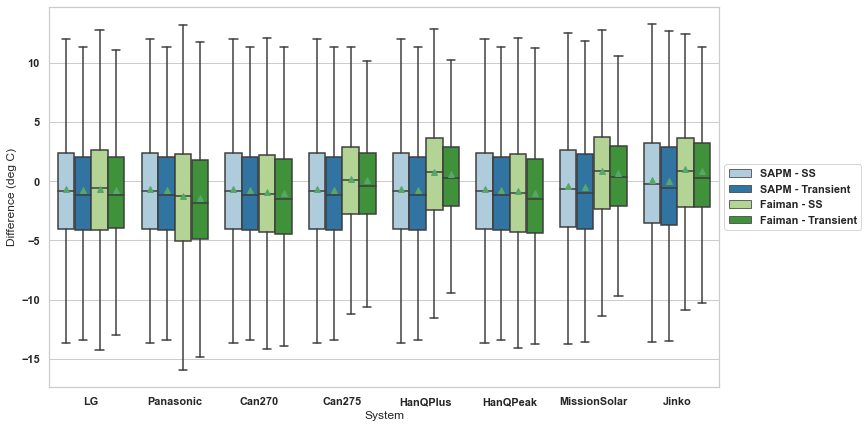

In [22]:
ax = sns.boxplot(x='System', y='Difference', hue='Model',data = results, showmeans=True, showfliers=False,palette='Paired')
#plt.ylim(-10,10)
plt.ylabel('Difference (deg C)')
#plt.title('Steady State model error against Mean RTD')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))